# 글로벌 이벤트에 따른 경제 구조의 변화 여부 및 국가 간 주가 동조화 현상 분석
### – 산업군별 비교를 중심으로

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

#### Investing.com에서 분류한 12가지 Sector의 분류데이터를 사용
- 2020년 10월 28일 기준 Sector 데이터

In [2]:
JPN = pd.read_csv("./일본 섹터별 분류 데이터.csv", encoding = 'utf-8') # 4자리수, .T ^N225
USA = pd.read_csv("./미국 섹터별 분류 데이터.csv", encoding = 'utf-8') # alphabet ^DJI
CHN = pd.read_csv("./중국 섹터별 분류 데이터.csv", encoding = 'utf-8') # 6자리수, .SS .SZ ^SSEC
KOR = pd.read_csv("./한국 섹터별 분류 데이터.csv", encoding = 'utf-8') # 6자리수 .KS .KQ ^KS11

JPN.Symbol = JPN.Symbol.astype('str')
CHN.Symbol = CHN.Symbol.astype('str')
KOR.Symbol = KOR.Symbol.astype('str')

KOR.Symbol = KOR.Symbol.apply(lambda x: x.zfill(6))
CHN.Symbol = CHN.Symbol.apply(lambda x: x.zfill(6))

sectors = list(KOR.Sector.unique())

In [3]:
sectors

['Basic Materials',
 'Capital Goods',
 'Conglomerates',
 'Consumer Cyclical',
 'Consumer Non-cyclical',
 'Energy',
 'Financial',
 'Healthcare',
 'Services',
 'Technology',
 'Transportation',
 'Utilities']

In [4]:
jpn_top5 = pd.DataFrame()
usa_top5 = pd.DataFrame()
chn_top5 = pd.DataFrame()
kor_top5 = pd.DataFrame()

for i in range(len(sectors)):
    if i == 0:
        usa_top5 = USA.loc[USA.Sector == sectors[i]][:5]
        jpn_top5 = JPN.loc[JPN.Sector == sectors[i]][:5]
        chn_top5 = CHN.loc[CHN.Sector == sectors[i]][:5]
        kor_top5 = KOR.loc[KOR.Sector == sectors[i]][:5]
    else:
        usa_top5 = usa_top5.append(USA.loc[USA.Sector == sectors[i]][:5], ignore_index = True) #BRK.B, BRK.A
        jpn_top5 = jpn_top5.append(JPN.loc[JPN.Sector == sectors[i]][:5], ignore_index = True)
        chn_top5 = chn_top5.append(CHN.loc[CHN.Sector == sectors[i]][:5], ignore_index = True)
        kor_top5 = kor_top5.append(KOR.loc[KOR.Sector == sectors[i]][:5], ignore_index = True)

||tick|거래소|시장 지수|
|--|---|----|-----|
|일본|4자리수|.T|닛케이(^N225)|
|미국|알파벳|(필요없음)|다우(^DJI)|
|중국|6자리수|.SS/.SZ|상하이종합지수(^SSEC)|
|한국|6자리수|.KS/.KQ|코스피(^KS11)|

#### PCA를 활용하여 글로벌 이벤트 발생 시기에 따른 국가별 주도 산업군을 알아봄

In [5]:
from sklearn.decomposition import PCA

In [6]:
def Data_processing(sdate, edate, country, df):
    new = pd.DataFrame()
    if country =='USA':
    # new["^DJI"] = yf.download("^DJI", start = sdate, end = edate)).Close
        for t in list(df.Symbol):
            try:
                price = yf.download(t, start = sdate, end = edate)
                new[t] = price.Close
            except:
                continue

    elif country == "JPN":
        for t in list(df.Symbol):
            try:
                price = yf.download(t+".T", start = sdate, end = edate)
                new[t] = price.Close
            except:
                continue

    elif country == "CHN":
        for t in list(df.Symbol):
            try:
                price = yf.download(t+".SS", start = sdate, end = edate)
          
                if len(price) == 0:
                    price = yf.download(t+".SZ", start = sdate, end = edate)
                new[t] = price.Close
            except:
                continue
    else:
        for t in list(df.Symbol):
            try:
                price = yf.download(t+".KS", start = sdate, end = edate)

                if len(price) == 0:
                    price = yf.download(t+".KQ", start = sdate, end = edate)
                new[t] = price.Close
            except:
                continue
    return new


def PCA_withTerm(df, file):

    # print(new.shape)
    df = df.apply(lambda x: (x-x.mean()) / x.std()).dropna(axis = 1)
    # print(new.shape)

    new = df.copy(deep = True)
    pca = PCA().fit(new)

    # print("Cumsum ratio: ", np.cumsum(pca.explained_variance_ratio_))

    pca_90, pca_95 = PCA(0.90).fit(new), PCA(0.95).fit(new)
    print("PCA >= 90% components: ", pca_90.n_components_, "\nPCA >= 95% components: ", pca_95.n_components_)

    pca = PCA().fit(new)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.axhline(0.9, c='r', ls='--' )
    plt.axhline(0.95, c='r', ls='--' )
    plt.axvline(pca_90.n_components_, c='g', ls='--' )
    plt.axvline(pca_95.n_components_, c='g', ls='--' )

    n = (pca_90.n_components_ + pca_95.n_components_) // 2
    pca = PCA(n_components = n)
    pca.fit(new)
    print("PCA explained variance: \n", pca.explained_variance_)
    print("PCA explained variance ratio: \n", pca.explained_variance_ratio_)


    projected = pca.fit_transform(new)
    corr = [np.corrcoef(projected[:, 0], new[tick])[0, 1] for tick in new.columns]

    data = pd.DataFrame({"Symbol": new.columns, "Corr": corr})
    data = data.sort_values(by = 'Corr', ascending = False).reset_index(drop = True)
    data = data.merge(file[['Symbol',"Name", 'Sector']], how = 'left', on = 'Symbol')
    
    return data

-----
## 2000-2001년
### 한국 외환위기 이후, 미국 911 테러

In [7]:
START_DATE = '2000-01-01'
END_DATE = "2001-12-31"

#### 2001년 미국
- 20개 데이터의 START_DATE가 맞지 않음

In [8]:
snp = yf.download("^GSPC", START_DATE, END_DATE).Close

[*********************100%***********************]  1 of 1 completed


In [9]:
usa01 = Data_processing(START_DATE, END_DATE, "USA",usa_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BHPLF: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BBL: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************] 

PCA >= 90% components:  7 
PCA >= 95% components:  12
PCA explained variance: 
 [17.59307596  4.35044719  4.05628171  2.55584486  1.96541078  1.15831284
  0.8331871   0.57100931  0.43907718]
PCA explained variance ratio: 
 [0.48869655 0.12084576 0.11267449 0.07099569 0.05459474 0.03217536
 0.02314409 0.01586137 0.01219659]


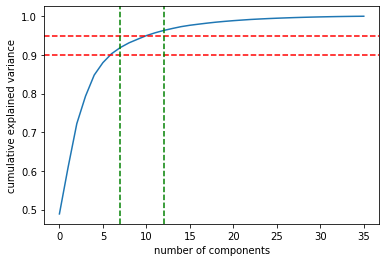

In [10]:
USA2001 = PCA_withTerm(usa01, usa_top5)

In [11]:
USA2001.head()

,Symbol,Corr,Name,Sector
0,AMZN,0.962369,Amazon.com,Services
1,ASML,0.944911,ASML ADR,Capital Goods
2,AAPL,0.914862,Apple,Technology
3,TM,0.891356,Toyota Motor ADR,Consumer Cyclical
4,MSFT,0.749528,Microsoft,Technology


In [12]:
USA2001.Sector.value_counts()

Capital Goods            5
Transportation           5
Consumer Non-cyclical    4
Utilities                4
Healthcare               3
Services                 3
Basic Materials          3
Energy                   2
Technology               2
Consumer Cyclical        2
Financial                2
Conglomerates            1
Name: Sector, dtype: int64

#### 2001년 일본
- 5개 데이터의 START_DATE가 맞지 않음

In [13]:
nik = yf.download("^N225", START_DATE, END_DATE).Close

[*********************100%***********************]  1 of 1 completed


In [14]:
jpn01 = Data_processing(START_DATE, END_DATE, "JPN", jpn_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

PCA >= 90% components:  8 
PCA >= 95% components:  11
PCA explained variance: 
 [14.23488107  4.84723952  3.21315116  1.25112956  1.16623162  0.72001774
  0.62844308  0.54310044  0.46728299]
PCA explained variance ratio: 
 [0.49085797 0.16714619 0.11079832 0.0431424  0.04021488 0.0248282
 0.02167045 0.0187276  0.01611321]


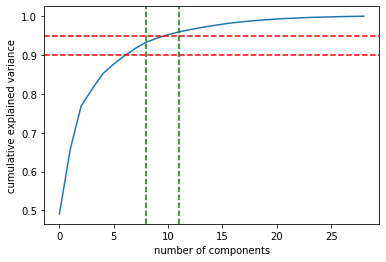

In [15]:
JPN2001 = PCA_withTerm(jpn01, jpn_top5)

In [16]:
JPN2001.head()

,Symbol,Corr,Name,Sector
0,6954,0.927480,Fanuc Corp.,Capital Goods
1,4503,0.926776,Astellas Pharma Inc.,Healthcare
2,6758,0.902085,Sony,Consumer Cyclical
3,3407,0.852600,Asahi Kasei Corp.,Basic Materials
4,4543,0.844671,Terumo Corp.,Healthcare


In [17]:
JPN2001.Sector.value_counts()

Capital Goods            5
Healthcare               5
Consumer Non-cyclical    4
Utilities                4
Basic Materials          4
Consumer Cyclical        3
Services                 2
Transportation           1
Energy                   1
Name: Sector, dtype: int64

#### 2001년 중국
- 46개 데이터의 START_DATE가 맞지 않음

In [18]:
ssec = yf.download("^SSEC", START_DATE, END_DATE).Close

[*********************100%***********************]  1 of 1 completed


In [19]:
chn01 = Data_processing(START_DATE, END_DATE, 'CHN', chn_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 601899.SS: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 601899.SZ: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 002493.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 002493.SZ: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 000651.SS: No data found, symbol may be delisted
[*********************100%*********

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 601288.SS: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 601288.SZ: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 300760.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 300760.SZ: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 603259.SS: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 603259.SZ: No data found, symbol may be delisted
[***

PCA >= 90% components:  3 
PCA >= 95% components:  4
PCA explained variance: 
 [6.28093264 1.30103561 0.57279109]
PCA explained variance ratio: 
 [0.6978814  0.14455951 0.06364345]


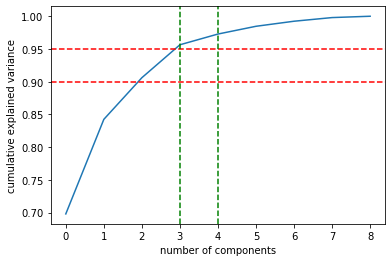

In [20]:
CHN2001 = PCA_withTerm(chn01, chn_top5)

In [21]:
CHN2001.head()

,Symbol,Corr,Name,Sector
0,600309,-0.313219,Wanhua Chemical,Basic Materials
1,000002,-0.713062,China Vanke A,Capital Goods
2,000858,-0.781564,Wuliangye A,Consumer Non-cyclical
3,600019,-0.865699,Baoshan Iron & Steel,Basic Materials
4,600276,-0.883579,Jiangsu Hengrui,Healthcare


In [22]:
CHN2001.Sector.value_counts()

Consumer Non-cyclical    2
Capital Goods            2
Basic Materials          2
Healthcare               1
Consumer Cyclical        1
Transportation           1
Name: Sector, dtype: int64

#### 2001년 한국
- 6개 데이터의 START_DATE가 맞지 않음

In [23]:
ks11 = yf.download("^KS11", START_DATE, END_DATE).Close

[*********************100%***********************]  1 of 1 completed


In [24]:
kor01 = Data_processing(START_DATE, END_DATE, "KOR", kor_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 051915.KS: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 051915.KQ: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 028260.KS: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 028260.KQ: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 02826K.KS: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 02826K.KQ: No data found, symbol may be delisted
[***

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 035420.KQ: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 006405.KS: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 006405.KQ: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 086280.KS: Data doesn't exist for startDate = 946652400, endDate = 1009724400
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 086280.KQ: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 180640.KS: Data doesn't exist for startDate = 946652400, endDa

PCA >= 90% components:  6 
PCA >= 95% components:  8
PCA explained variance: 
 [11.10521831  6.38176858  3.23828282  0.98699472  0.74161839  0.71506204
  0.40502558]
PCA explained variance ratio: 
 [0.44420873 0.25527074 0.12953131 0.03947979 0.02966474 0.02860248
 0.01620102]


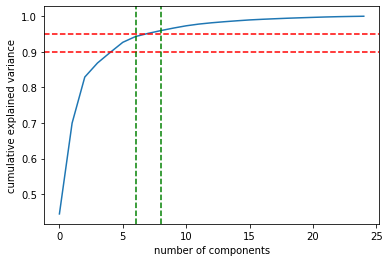

In [25]:
KOR2001 = PCA_withTerm(kor01, kor_top5)

In [26]:
KOR2001.head()

,Symbol,Corr,Name,Sector
0,055550,0.933090,Shinhan Financial Group,Financial
1,051910,0.929901,LG Chemicals,Basic Materials
2,006120,0.911264,SK Discovery,Utilities
3,005389,0.892446,Hyundai,Consumer Cyclical
4,000810,0.855792,Samsung Fire Marine Insur,Financial


In [27]:
KOR2001.Sector.value_counts()

Utilities                4
Capital Goods            3
Transportation           3
Consumer Cyclical        3
Services                 3
Consumer Non-cyclical    2
Basic Materials          2
Technology               2
Financial                2
Healthcare               1
Name: Sector, dtype: int64

-----
## 2007-2008년
### 세계 금융위기

In [28]:
START_DATE2 = '2007-01-01'
END_DATE2 = '2008-12-31'

#### 2007년 미국

In [29]:
snp2 = yf.download("^GSPC", START_DATE2, END_DATE2).Close
usa07 = Data_processing(START_DATE2, END_DATE2, "USA",usa_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BHPLF: Data doesn't exist for startDate = 1167577200, endDate = 1230649200
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Fai

PCA >= 90% components:  7 
PCA >= 95% components:  12
PCA explained variance: 
 [17.59307596  4.35044719  4.05628171  2.55584486  1.96541078  1.15831284
  0.8331871   0.57100931  0.43907718]
PCA explained variance ratio: 
 [0.48869655 0.12084576 0.11267449 0.07099569 0.05459474 0.03217536
 0.02314409 0.01586137 0.01219659]


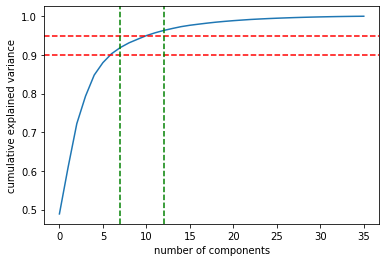

In [30]:
USA2007 = PCA_withTerm(usa01, usa_top5)

In [31]:
USA2007.head()

,Symbol,Corr,Name,Sector
0,AMZN,0.962369,Amazon.com,Services
1,ASML,0.944911,ASML ADR,Capital Goods
2,AAPL,0.914862,Apple,Technology
3,TM,0.891356,Toyota Motor ADR,Consumer Cyclical
4,MSFT,0.749528,Microsoft,Technology


In [32]:
USA2007.Sector.value_counts()

Capital Goods            5
Transportation           5
Consumer Non-cyclical    4
Utilities                4
Healthcare               3
Services                 3
Basic Materials          3
Energy                   2
Technology               2
Consumer Cyclical        2
Financial                2
Conglomerates            1
Name: Sector, dtype: int64

#### 2007년 일본

In [33]:
nik2 = yf.download("^N225", START_DATE2, END_DATE2).Close

[*********************100%***********************]  1 of 1 completed


In [34]:
jpn07 = Data_processing(START_DATE2, END_DATE2, "JPN", jpn_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

PCA >= 90% components:  5 
PCA >= 95% components:  8
PCA explained variance: 
 [34.81039997  7.89310008  2.34642114  1.49275725  1.25728552  0.72168526]
PCA explained variance ratio: 
 [0.66943077 0.15179039 0.04512348 0.02870687 0.02417857 0.01387856]


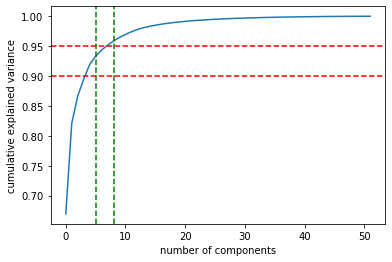

In [35]:
JPN2007 = PCA_withTerm(jpn07, jpn_top5)

In [36]:
JPN2007.head()

,Symbol,Corr,Name,Sector
0,9983,0.511252,Fast Retailing,Services
1,8113,0.222226,Unicharm Co,Consumer Non-cyclical
2,4543,-0.114880,Terumo Corp.,Healthcare
3,7974,-0.141225,Nintendo,Consumer Cyclical
4,2413,-0.308003,M3 Inc,Technology


In [37]:
JPN2007.Sector.value_counts()

Capital Goods            5
Energy                   5
Consumer Non-cyclical    5
Basic Materials          5
Technology               5
Consumer Cyclical        5
Utilities                5
Healthcare               5
Financial                4
Transportation           4
Services                 4
Name: Sector, dtype: int64

#### 2007년 중국

In [38]:
ssec2 = yf.download("^SSEC", START_DATE2, END_DATE2).Close

[*********************100%***********************]  1 of 1 completed


In [39]:
chn07 = Data_processing(START_DATE2, END_DATE2, 'CHN', chn_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 002493.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 002493.SZ: Data doesn't exist for startDate = 1167577200, endDate = 1230649200
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 000651.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 000002.SS: Data doesn't exist for startDate = 1167577200, endDate = 1230649200
[*********************100%*********

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 002027.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 300750.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 300750.SZ: Data doesn't exist for startDate = 1167577200, endDate = 1230649200
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 002475.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 002475.SZ: Data doesn't exist for startDate = 1167577200, endDate = 1230649200
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 601138.SS: Data doesn't exist for startDate = 1167577200, endDate = 1230649200
[

PCA >= 90% components:  3 
PCA >= 95% components:  5
PCA explained variance: 
 [15.95542479  2.60460163  0.69603442  0.54677579]
PCA explained variance ratio: 
 [0.75978213 0.12402865 0.0331445  0.02603694]


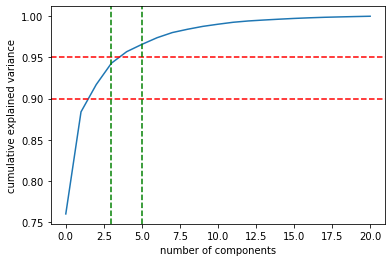

In [40]:
CHN2007 = PCA_withTerm(chn07, chn_top5)

In [41]:
CHN2007.head()

,Symbol,Corr,Name,Sector
0,000858,0.975753,Wuliangye A,Consumer Non-cyclical
1,600019,0.971096,Baoshan Iron & Steel,Basic Materials
2,600585,0.965745,Anhui Conch Cement,Capital Goods
3,601111,0.957289,Air China A,Transportation
4,600104,0.945417,SAIC Motor Corp,Consumer Cyclical


In [42]:
CHN2007.Sector.value_counts()

Capital Goods            4
Consumer Non-cyclical    3
Basic Materials          3
Services                 3
Transportation           2
Utilities                2
Healthcare               1
Technology               1
Consumer Cyclical        1
Financial                1
Name: Sector, dtype: int64

#### 2007년 한국

In [43]:
ks112 = yf.download("^KS11", START_DATE2, END_DATE2).Close

[*********************100%***********************]  1 of 1 completed


In [44]:
kor07 = Data_processing(START_DATE2, END_DATE2, "KOR", kor_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 028260.KS: Data doesn't exist for startDate = 1167577200, endDate = 1230649200
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 028260.KQ: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


PCA >= 90% components:  5 
PCA >= 95% components:  7
PCA explained variance: 
 [9.22208279 4.76447544 2.45469431 1.32235534 0.75688819 0.2923142 ]
PCA explained variance ratio: 
 [0.46110414 0.23822377 0.12273472 0.06611777 0.03784441 0.01461571]


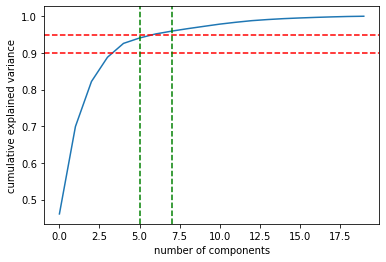

In [45]:
KOR2007 = PCA_withTerm(kor07, kor_top5)

In [46]:
KOR2007.head()

,Symbol,Corr,Name,Sector
0,018880,-0.090262,Hanon Systems,Capital Goods
1,033780,-0.176131,KT&G Corp,Consumer Non-cyclical
2,017670,-0.287810,SK Telecom,Services
3,015760,-0.414594,Kepco,Utilities
4,000660,-0.446195,SK Hynix Inc,Technology


In [47]:
KOR2007.Sector.value_counts()

Capital Goods            3
Utilities                3
Basic Materials          2
Transportation           2
Services                 2
Technology               2
Consumer Cyclical        2
Financial                2
Consumer Non-cyclical    1
Energy                   1
Name: Sector, dtype: int64

-----
## 2020년
### 전 세계 코로나 바이러스 확산

In [48]:
START_DATE3 = '2020-01-01'
END_DATE3 = '2020-10-29'

#### 2020년 미국

In [49]:
snp3 = yf.download("^GSPC", START_DATE3, END_DATE3).Close

[*********************100%***********************]  1 of 1 completed


In [50]:
usa20 = Data_processing(START_DATE3, END_DATE3, 'USA', usa_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

PCA >= 90% components:  4 
PCA >= 95% components:  7
PCA explained variance: 
 [29.65510913 15.36644747  2.92029397  1.70869945  1.29808441]
PCA explained variance ratio: 
 [0.5391838  0.27938995 0.05309625 0.03106726 0.02360153]


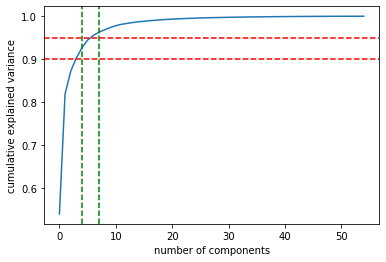

In [51]:
USA2020 = PCA_withTerm(usa20, usa_top5)

In [52]:
USA2020

,Symbol,Corr,Name,Sector
0,RYDAF,-0.014009,Royal Dutch Shell A,Energy
1,PTR,-0.064301,PetroChina ADR,Energy
2,XOM,-0.115429,Exxon Mobil,Energy
3,CVX,-0.214216,Chevron,Energy
4,MRCR,-0.218484,Moro,Conglomerates
5,SO,-0.231788,Southern,Utilities
6,SXC,-0.248502,SunCoke Energy,Conglomerates
7,BA,-0.314516,Boeing,Capital Goods
8,ENB,-0.354735,Enbridge,Utilities
9,DUK,-0.360633,Duke Energy,Utilities


In [53]:
USA2020.head()

,Symbol,Corr,Name,Sector
0,RYDAF,-0.014009,Royal Dutch Shell A,Energy
1,PTR,-0.064301,PetroChina ADR,Energy
2,XOM,-0.115429,Exxon Mobil,Energy
3,CVX,-0.214216,Chevron,Energy
4,MRCR,-0.218484,Moro,Conglomerates


In [54]:
USA2020.Sector.value_counts()

Capital Goods            5
Consumer Non-cyclical    5
Basic Materials          5
Healthcare               5
Transportation           5
Consumer Cyclical        5
Technology               5
Services                 5
Utilities                5
Energy                   4
Conglomerates            3
Financial                3
Name: Sector, dtype: int64

#### 2020년 일본

In [55]:
nik3 = yf.download("^N225", START_DATE3, END_DATE3).Close

[*********************100%***********************]  1 of 1 completed


In [56]:
jpn20 = Data_processing(START_DATE3, END_DATE3, "JPN", jpn_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

PCA >= 90% components:  4 
PCA >= 95% components:  7
PCA explained variance: 
 [23.32206086 21.02053056  5.13277877  2.09546212  1.09919301]
PCA explained variance ratio: 
 [0.40915896 0.36878124 0.09004875 0.03676249 0.01928409]


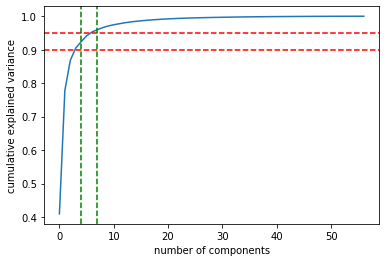

In [57]:
JPN2020 = PCA_withTerm(jpn20, jpn_top5)

In [58]:
JPN2020.head()

,Symbol,Corr,Name,Sector
0,2768,0.958983,Sojitz Corp.,Energy
1,1605,0.958545,Inpex Corp.,Energy
2,5019,0.953491,Idemitsu Kosan Co Ltd,Energy
3,9022,0.942091,Central Japan Railway Co.,Transportation
4,9020,0.932584,East Japan Railway Co.,Transportation


In [59]:
JPN2020.Sector.value_counts()

Capital Goods            5
Energy                   5
Consumer Non-cyclical    5
Basic Materials          5
Healthcare               5
Transportation           5
Consumer Cyclical        5
Technology               5
Services                 5
Utilities                5
Financial                5
Conglomerates            2
Name: Sector, dtype: int64

#### 2020년 중국

In [60]:
ssec3 = yf.download("^SSEC", START_DATE3, END_DATE3).Close

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ^SSEC: No data found for this date range, symbol may be delisted


In [61]:
chn20 = Data_processing(START_DATE3, END_DATE3, "CHN", chn_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 002493.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 000651.SS: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%****

PCA >= 90% components:  5 
PCA >= 95% components:  8
PCA explained variance: 
 [29.85155129 15.29742318  2.57778901  2.3916778   1.65655548  1.14108962]
PCA explained variance ratio: 
 [0.52371143 0.26837585 0.04522437 0.04195926 0.02906238 0.02001912]


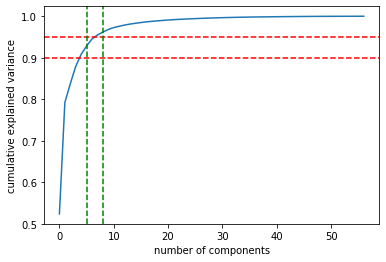

In [62]:
CHN2020 = PCA_withTerm(chn20, chn_top5)

In [63]:
CHN2020.head()

,Symbol,Corr,Name,Sector
0,002352,0.980593,S.F. Holding Co,Transportation
1,000858,0.978501,Wuliangye A,Consumer Non-cyclical
2,601012,0.974733,Xian LONGi Silicon Materials,Technology
3,002493,0.959219,Rongsheng A,Basic Materials
4,300274,0.951405,Sungrow Power Supply,Conglomerates


In [64]:
CHN2020.Sector.value_counts()

Capital Goods            5
Consumer Non-cyclical    5
Basic Materials          5
Financial                5
Consumer Cyclical        5
Energy                   5
Technology               5
Services                 5
Utilities                5
Healthcare               5
Transportation           4
Conglomerates            3
Name: Sector, dtype: int64

#### 2020년 한국

In [65]:
ks113 = yf.download("^KS11", START_DATE3, END_DATE3).Close

[*********************100%***********************]  1 of 1 completed


In [66]:
kor20 = Data_processing(START_DATE3, END_DATE3, "KOR", kor_top5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

PCA >= 90% components:  5 
PCA >= 95% components:  8
PCA explained variance: 
 [23.8072971  18.57032636  4.63284237  1.58932234  1.00897178  0.87037623]
PCA explained variance ratio: 
 [0.44087587 0.34389493 0.08579338 0.0294319  0.01868466 0.01611808]


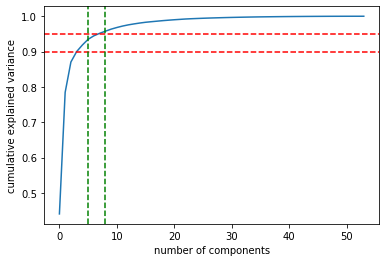

In [67]:
KOR2020 = PCA_withTerm(kor20, kor_top5)

In [68]:
KOR2020.head()

,Symbol,Corr,Name,Sector
0,180640,0.182242,Hanjinkal,Transportation
1,010950,-0.173344,S-Oil Corp,Energy
2,03473K,-0.242885,SK Holdings,Energy
3,068270,-0.291834,Celltrion,Healthcare
4,032640,-0.299791,LG Uplus,Services


In [69]:
KOR2020.Sector.value_counts()

Capital Goods            5
Energy                   5
Consumer Non-cyclical    5
Basic Materials          5
Financial                5
Transportation           5
Consumer Cyclical        5
Technology               5
Services                 5
Utilities                5
Healthcare               3
Conglomerates            1
Name: Sector, dtype: int64